In [1]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 29.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/5008 Project

/content/drive/.shortcut-targets-by-id/1bBIjKsvs3fOfhtXtLG83N0fVmT-uhzTl/5008 Project


In [4]:
import pandas as pd
import networkx as nx
import dgl

import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Preprocessing

In [ ]:
# # original csv
# df = pd.read_csv("all.csv", index_col = 0)
# df = df[['src_ap_id','des_ap_id','ap_type','in_deg_cent', 'out_deg_cent', 'btw_cent', 'cls_cent', 'eigen_cent']]
# df['ap_type'] = df['ap_type'].apply(lambda x: 2 if x == 'large_airport' else (1 if x == 'medium_airport' else 0))
# df['feat'] = df.apply(lambda x: str(x['in_deg_cent']) +","+ str(x["out_deg_cent"])+","+ str(x["btw_cent"])+","+ str(x["cls_cent"])+","+ str(x["eigen_cent"]), axis = 1)
# # creating edges.csv
# edge = df.rename(columns = {'src_ap_id':'src_id', 'des_ap_id':'dst_id'})[['src_id','dst_id']]
# id_src = list(edge['src_id'])
# edge = edge.query("dst_id in @id_src")
# edge.to_csv("node_classifcation_airport/edges.csv", index=0)
# # creating nodes.csv
# node = df[['src_ap_id','ap_type','feat']]
# node.columns = ['node_id','label','feat']
# node.drop_duplicates(inplace = True)
# node.to_csv("node_classifcation_airport/nodes.csv", index = 0)

The preprocessing is done and the CSV files (node.csv and edges.csv) and put into a folder called "node_classifcation_airport".
This is the data that is used for Node Classification down below.

# Node Classification

In [5]:
dataset = dgl.data.CSVDataset('./Final_Code/Node Classification/node_classification_airport/')
g = dataset[0]  # only one graph
print(g)

Done loading data from cached files.
Graph(num_nodes=3409, num_edges=67641,
      ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})


In [7]:
dgl.data.utils.add_nodepred_split(dataset, [0.6, 0.2, 0.2])

In [8]:
from dgl.nn import SAGEConv


class Model(nn.Module):
    def __init__(self, input_feats):
        super(Model, self).__init__()
        
        self.conv1 = SAGEConv(input_feats, 128*4, 'mean')
        self.conv2 = SAGEConv(128*4, 64*4, 'mean')
        self.conv3 = SAGEConv(64*4, 16*4, 'mean')

    def forward(self, g, in_feat):
        
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g, h)
            
        return h
    

class Classifier(nn.Module):
    def __init__(self, h_feat, num_classes):
        super(Classifier, self).__init__()

        self.linear1 = torch.nn.Linear(h_feat, 100)
        self.linear2 = torch.nn.Linear(100, 50)
        self.linear3 = torch.nn.Linear(50, num_classes)
        
    def forward(self, in_feat):

        h = nn.functional.relu(self.linear1(in_feat))
        h = nn.functional.relu(self.linear2(h))
        h = self.linear3(h)
        
        return h

In [13]:
import itertools
loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

classifier = Classifier(16*4, 3)
model = Model(g.ndata["feat"].shape[1])
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), classifier.parameters()), lr=0.015)
criterion = nn.CrossEntropyLoss()
best_val_acc = 0
best_test_acc = 0

features = g.ndata["feat"]
labels = g.ndata["label"]
train_mask = g.ndata["train_mask"]
val_mask = g.ndata["val_mask"]
test_mask = g.ndata["test_mask"]

for e in range(500):

    hidden = model(g, features)
    logits = classifier(hidden)

    pred = torch.argmax(logits, dim=1)

    loss = criterion(logits[train_mask], labels[train_mask])
    
    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
    
    loss_values.append(loss.detach().numpy())
    train_acc_values.append(train_acc.detach().numpy())
    val_acc_values.append(val_acc.detach().numpy())
    test_acc_values.append(test_acc.detach().numpy())

    # Save the best validation accuracy and the corresponding test accuracy.
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print(
            "In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc
            )
        )

In epoch 0, loss: 1.106, val acc: 0.123 (best 0.123), test acc: 0.123 (best 0.123)
In epoch 5, loss: 1.142, val acc: 0.712 (best 0.714), test acc: 0.714 (best 0.713)
In epoch 10, loss: 0.856, val acc: 0.714 (best 0.714), test acc: 0.713 (best 0.713)
In epoch 15, loss: 0.830, val acc: 0.714 (best 0.714), test acc: 0.713 (best 0.713)
In epoch 20, loss: 0.833, val acc: 0.714 (best 0.714), test acc: 0.713 (best 0.713)
In epoch 25, loss: 0.833, val acc: 0.714 (best 0.714), test acc: 0.713 (best 0.713)
In epoch 30, loss: 0.818, val acc: 0.714 (best 0.714), test acc: 0.713 (best 0.713)
In epoch 35, loss: 0.788, val acc: 0.714 (best 0.714), test acc: 0.713 (best 0.713)
In epoch 40, loss: 0.747, val acc: 0.714 (best 0.714), test acc: 0.713 (best 0.713)
In epoch 45, loss: 0.828, val acc: 0.626 (best 0.717), test acc: 0.612 (best 0.709)
In epoch 50, loss: 0.729, val acc: 0.714 (best 0.717), test acc: 0.713 (best 0.709)
In epoch 55, loss: 0.721, val acc: 0.736 (best 0.736), test acc: 0.738 (best 0

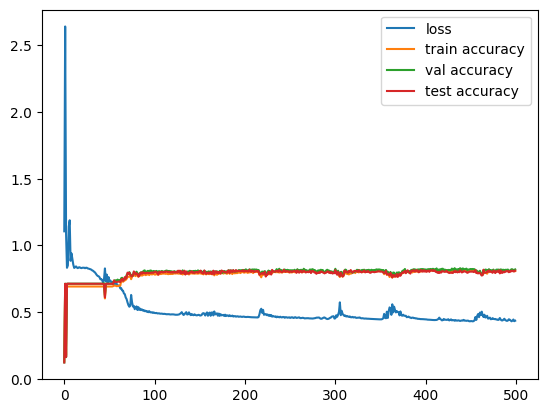

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(500), loss_values, label = 'loss')
plt.plot(range(500), train_acc_values, label = 'train accuracy')
plt.plot(range(500), val_acc_values, label = 'val accuracy')
plt.plot(range(500), test_acc_values, label = 'test accuracy')
plt.legend()

In [22]:
import pandas as pd
df = pd.read_csv("././Transformed_Data/route_key_attributes.csv", index_col = 0)
df = df[['latitude_deg', 'longitude_deg', 'small_airport','medium_airport', 'large_airport']].dropna()

In [24]:
import folium
import pandas as pd

#create a map
this_map = folium.Map(prefer_canvas=True)

def plotDot(point):
    radius_dict = {'large_airport':8, 'medium_airport':6, 'small_airport':4}
    if point['small_airport'] == 1:
        radius = 4
        folium.CircleMarker(location=[point.latitude_deg, point.longitude_deg], fill=True, color = '#2bb810', radius = radius, fill_opacity=1).add_to(this_map)
    elif point['medium_airport'] == 1:
        radius = 6
        folium.CircleMarker(location=[point.latitude_deg, point.longitude_deg], fill=True, color = '#2c2c92', radius = radius, fill_opacity=1).add_to(this_map)
    else:
        radius = 8
        folium.CircleMarker(location=[point.latitude_deg, point.longitude_deg], fill=True, color = '#f20000', radius = radius, fill_opacity=1).add_to(this_map)
    
#use df.apply(,axis=1) to "iterate" through every row in your dataframe
df.apply(plotDot, axis = 1)

#Set the zoom to the maximum possible
this_map.fit_bounds(this_map.get_bounds())

In [25]:
this_map